# Setup

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="3"
os.environ["CUDA_LAUNCH_BLOCKING"]="1, 2, 3, 4"

In [2]:
import torch
import random
import numpy as np
import pandas as pd
from numpy.ma import masked_where

In [3]:
from sklearn.preprocessing import normalize
from torch.utils.data import Dataset, DataLoader
from torchsampler import ImbalancedDatasetSampler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import f1_score, precision_score, recall_score

# Import Data

In [4]:
items = pd.read_csv("../Datasets/ml-100k/Text/items.csv")

r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('../Datasets/ml-100k/Text/u1.base', sep='\t', names=r_cols,encoding='latin-1')

In [5]:
n_users = 943
n_items = 1682

In [6]:
data_matrix = np.zeros((n_users, n_items))
for line in ratings.itertuples():
    data_matrix[line[1]-1, line[2]-1] = line[3]

In [7]:
data_matrix_emp = data_matrix.copy()
data_matrix_emp[data_matrix < 4] = 0
data_matrix_emp[data_matrix >= 4]= 1 

In [8]:
train_indices = list(zip(*(np.where(data_matrix != 0))))

In [9]:
len(train_indices)

80000

# Siamese network

## Data loader

In [10]:
torch.cuda.is_available()

True

In [11]:
torch.__version__

'1.10.1'

In [12]:
items_csv = "../Datasets/ml-100k/Text/items.csv"
train_ratings = "../Datasets/ml-100k/Text/u1.base"
test_ratings = "../Datasets/ml-100k/Text/u1.test"

item_path = "../Datasets/ml-100k/"

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [14]:
class MovielensDataset(Dataset):
    def __init__(self, ratings = train_ratings, item_path = item_path, device = device):
        self.video_embeddings = pd.read_csv(item_path + "Video/embeddings.csv").to_numpy()
        self.audio_embeddings = pd.read_csv(item_path + "Fusion/embeddings.csv").to_numpy()
        self.meta_embeddings = pd.read_csv(item_path + "Meta/embeddings.csv").to_numpy()
        self.text_embeddings = pd.read_csv(item_path + "Text/embeddings.csv").to_numpy()
        self.ratings = pd.read_csv(ratings, sep='\t', 
                                   names=['user_id', 'movie_id', 'rating', 'unix_timestamp'],encoding='latin-1')
        self.indices = None
        self.device = device
        self.data = None
        self.n_users = None
        self.n_items = None
        self.fill_ratings()
        self.embeddings()
    
    def fill_ratings(self, threshold=4):
        self.n_users = self.ratings.user_id.unique().shape[0]
        self.n_items = self.ratings.movie_id.unique().shape[0]
        
        self.data = np.zeros((n_users, n_items))
        for line in self.ratings.itertuples():
            self.data[line[1]-1, line[2]-1] = line[3]
        
        self.data_emp = np.where(np.logical_and(self.data > 3,
                            np.random.random_sample(self.data.shape) <= 0.2), 1, 0)
        self.indices = list(zip(*(np.where(self.data != 0))))
            
    def embeddings(self):
        self.audio_embeddings = np.nan_to_num(self.audio_embeddings)
        self.video_embeddings = np.nan_to_num(self.video_embeddings)
        self.audio_embeddings = normalize(self.audio_embeddings, axis = 0)
        self.user_embeddings = np.divide(np.dot(self.data_emp, self.meta_embeddings), 
                                         self.data_emp.sum(axis = 1)[:, None] + 0.001)
#         self.user_embeddings = data_matrix
        self.item_embeddings = data_matrix.T
        self.video_embedding_size = self.video_embeddings.shape[1]
        self.audio_embedding_size = self.audio_embeddings.shape[1]
        self.text_embedding_size = self.text_embeddings.shape[1]
        self.user_embedding_size = self.user_embeddings.shape[1]
        self.item_embedding_size = self.item_embeddings.shape[1]
        self.meta_embedding_size = self.meta_embeddings.shape[1]
        
    def __len__(self):
        return(len(self.indices))
    
    def __getitem__(self, idx):
        user = self.indices[idx][0]
        item = self.indices[idx][1]

        xu = torch.from_numpy(self.user_embeddings[user]).to(self.device)
        xv = torch.from_numpy(self.video_embeddings[item]).to(self.device)
        xa = torch.from_numpy(self.audio_embeddings[item]).to(self.device)
        xt = torch.from_numpy(self.text_embeddings[item]).to(self.device)
        xi = torch.from_numpy(self.item_embeddings[item]).to(self.device)
        xm = torch.from_numpy(self.meta_embeddings[item]).to(self.device)
        
        y = self.data[user][item]
        return(xu.float(), [xv.float(), xa.float(), xt.float(), xi.float(), xm.float()], int(y))

In [15]:
train_dataset = MovielensDataset(ratings = train_ratings)
test_dataset = MovielensDataset(ratings = test_ratings)

In [16]:
trainloader = DataLoader(train_dataset, batch_size = 40000, shuffle = True)
testloader = DataLoader(test_dataset, batch_size = 20000, shuffle = False)

## Architecture

In [17]:
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import OrderedDict

In [18]:
from ml_metrics import mapk
from recmetrics import mark

In [19]:
class SiameseNet(nn.Module):
    def __init__(self, device = device):
        super(SiameseNet, self).__init__()
        self.encoder_user = nn.Sequential(OrderedDict([
            ('linr1', nn.Linear(train_dataset.user_embedding_size, 1024)),
            ('relu1', nn.Sigmoid()),
            ('linr2', nn.Linear(1024, 200)),
            ('relu2', nn.LeakyReLU()),
        ]))
        
        self.encoder_item = nn.Sequential(OrderedDict([
            ('linr1', nn.Linear(train_dataset.item_embedding_size, 256)),
            ('relu1', nn.Sigmoid()),
            ('linr2', nn.Linear(256, 400)),
            ('relu2', nn.Sigmoid()),
        ]))
        
        self.encoder_video = nn.Sequential(OrderedDict([
            ('linr1', nn.Linear(train_dataset.video_embedding_size, 1600)),
            ('relu1', nn.Sigmoid()),
            ('linr2', nn.Linear(1600, 1000)),
            ('relu2', nn.Sigmoid()),
            ('linr3', nn.Linear(1000, 500)),
            ('relu3', nn.LeakyReLU()),
            ('linr4', nn.Linear(500, 200)),
            ('relu4', nn.LeakyReLU()),
        ]))
        
        self.encoder_audio = nn.Sequential(OrderedDict([
            ('linr1', nn.Linear(train_dataset.audio_embedding_size, 100)),
            ('relu1', nn.LeakyReLU()),
#             ('linr2', nn.Linear(1000, 800)),
#             ('relu2', nn.LeakyReLU()),
#             ('linr3', nn.Linear(800, 500)),
#             ('relu3', nn.LeakyReLU()),
            ('linr4', nn.Linear(100, 200)),
            ('relu4', nn.LeakyReLU()),
        ]))
        
        self.encoder_text = nn.Sequential(OrderedDict([
            ('linr1', nn.Linear(train_dataset.text_embedding_size, 256)),
            ('relu1', nn.LeakyReLU()),
            ('linr2', nn.Linear(256, 200)),
            ('relu2', nn.LeakyReLU()),
        ]))
        
        self.encoder_meta = nn.Sequential(OrderedDict([
            ('linr1', nn.Linear(train_dataset.meta_embedding_size, 1600)),
            ('relu1', nn.LeakyReLU()),
            ('linr2', nn.Linear(1600, 1000)),
            ('relu2', nn.LeakyReLU()),
            ('linr3', nn.Linear(1000, 500)),
            ('relu3', nn.LeakyReLU()),
            ('linr4', nn.Linear(500, 200)),
            ('relu4', nn.LeakyReLU()),
        ]))
        
        self.siamese = nn.Sequential(OrderedDict([
            ('linr1', nn.Linear(200, 512)),
            ('relu1', nn.LeakyReLU()),
            ('linr2', nn.Linear(512, 256)),
            ('relu2', nn.LeakyReLU()),
            ('linr3', nn.Linear(256, 100)),
            ('relu3', nn.LeakyReLU()),
        ]))
        
        self.ffn = nn.Sequential(OrderedDict([
            ('linr1', nn.Linear(200, 164)),
            ('actv1', nn.LeakyReLU()),
            ('linr2', nn.Linear(164, 50)),
            ('actv2', nn.LeakyReLU()),
            ('linr3', nn.Linear(50, 1)),
        ]))
        
        self.device = device
        self.encoder_user.apply(self.init_weights)
        self.encoder_item.apply(self.init_weights)
        self.encoder_video.apply(self.init_weights)
        self.encoder_audio.apply(self.init_weights)
        self.encoder_text.apply(self.init_weights)
        self.siamese.apply(self.init_weights)
        self.ffn.apply(self.init_weights)
        
    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight)
            m.bias.data.fill_(0.01)
        
    def forward(self, x1, x2):
        outu = self.encoder_user(x1)
        outr = self.encoder_item(x2[3])
        outv = self.encoder_video(x2[0])
        outa = self.encoder_audio(x2[1])
        outt = self.encoder_text(x2[2])
        outm = self.encoder_meta(x2[4])
#         outi = torch.cat((outa, outt), axis=1)
        outi = outa
        out1 = self.siamese(outu)
        out2 = self.siamese(outi)
        diff = torch.cat((out1, out2), axis=1)
        out = self.ffn(diff)
        return(out, out1, out2)
    
    def fit(self, trainloader = trainloader, 
            testloader = testloader, epochs = 100):
        self.criterion_rate = nn.MSELoss()
        self.criterion_embd = nn.CosineEmbeddingLoss()
        self.optimizer = optim.Adam(self.parameters(), lr = 1e-3)
        
        train_loss = []
        train_f1 = []
        test_loss = []
        test_f1 = []
        for epoch in range(epochs):
            running_loss = 0.0
            running_loss_1 = 0.0
            
            for i, data in tqdm(enumerate(trainloader)):
                self.train()
                x1, x2, y = data
                y_flt = y.type(torch.FloatTensor).to(device)
                y_lng = torch.div(y, 4, rounding_mode="floor").to(device)
                self.optimizer.zero_grad()
                reg, outu, outi = self.forward(x1, x2)
                loss_1 = self.criterion_rate(reg.squeeze(), y_flt)
                loss_2 = self.criterion_embd(outu, outi, y_lng * 2 - 1)
                loss = loss_1 + loss_2 
                loss.backward()
                self.optimizer.step()

                running_loss_1 += torch.sqrt(loss_1)
                running_loss += loss
            vl, vp, vr, vf, tp, tr, tf = self.evaluate()
            print('Epoch-%d: Loss = %.3f\nTrain RMSE = %.3f||Train Precision = %.3f||Train Recall = %.3f\nTest RMSE = %.3f || Test Precision = %.3f|| Test Recall = %.3f'%
                  (epoch + 1, running_loss / i, running_loss_1 / i, 
                   tp, tr, vl, vp, vr))
            train_loss.append((running_loss_1 / i).cpu().detach().numpy())
            test_loss.append(vl.cpu().detach().numpy())
            train_f1.append(tf)
            test_f1.append(vf)
        return(train_loss, test_loss, train_f1, test_f1)
            
    def evaluate(self, k = 3.5):
        self.eval()
        with torch.no_grad():
            valdata = next(iter(testloader))
            x1, x2, y = valdata
            y_flt = y.type(torch.FloatTensor).to(device)
            y_lng = torch.div(y, 4, rounding_mode="floor").to(device)
            otpt = self.forward(x1, x2)
            print(otpt[0])
            pred = (otpt[0] > k).float()
            vl = torch.sqrt(self.criterion_rate(otpt[0].squeeze(), y_flt))
            vp = precision_score(y_lng.cpu(), pred.cpu(), zero_division = 0)
            vr = recall_score(y_lng.cpu(), pred.cpu(), zero_division = 0)
            vf = f1_score(y_lng.cpu(), pred.cpu(), zero_division = 0)
            print(classification_report(y_lng.cpu(), pred.cpu(),
                    target_names = ["0", "1"], zero_division = 0))
            
            traindata = next(iter(trainloader))
            x1, x2, y = traindata
            y_flt = y.type(torch.FloatTensor).to(device)
            y_lng = torch.div(y, 4, rounding_mode="floor").to(device)
            otpt = self.forward(x1, x2)
            pred = (otpt[0] > k).float()
            tp = precision_score(y_lng.cpu(), pred.cpu(), zero_division = 0)
            tr = recall_score(y_lng.cpu(), pred.cpu(), zero_division = 0)
            tf = f1_score(y_lng.cpu(), pred.cpu(), zero_division = 0)
        return(vl, vp*100, vr*100, vf*100, tp*100, tr*100, tf*100)

In [20]:
sm_net = SiameseNet()
sm_net.to(device)

SiameseNet(
  (encoder_user): Sequential(
    (linr1): Linear(in_features=1220, out_features=1024, bias=True)
    (relu1): Sigmoid()
    (linr2): Linear(in_features=1024, out_features=200, bias=True)
    (relu2): LeakyReLU(negative_slope=0.01)
  )
  (encoder_item): Sequential(
    (linr1): Linear(in_features=943, out_features=256, bias=True)
    (relu1): Sigmoid()
    (linr2): Linear(in_features=256, out_features=400, bias=True)
    (relu2): Sigmoid()
  )
  (encoder_video): Sequential(
    (linr1): Linear(in_features=2048, out_features=1600, bias=True)
    (relu1): Sigmoid()
    (linr2): Linear(in_features=1600, out_features=1000, bias=True)
    (relu2): Sigmoid()
    (linr3): Linear(in_features=1000, out_features=500, bias=True)
    (relu3): LeakyReLU(negative_slope=0.01)
    (linr4): Linear(in_features=500, out_features=200, bias=True)
    (relu4): LeakyReLU(negative_slope=0.01)
  )
  (encoder_audio): Sequential(
    (linr1): Linear(in_features=300, out_features=100, bias=True)
    (

In [21]:
train_loss, test_loss, train_f1, test_f1 = sm_net.fit()

2it [00:36, 18.12s/it]


tensor([[5.8287],
        [5.8287],
        [5.8287],
        ...,
        [5.6558],
        [5.6558],
        [5.6558]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      8765
           1       0.56      1.00      0.72     11235

    accuracy                           0.56     20000
   macro avg       0.28      0.50      0.36     20000
weighted avg       0.32      0.56      0.40     20000

Epoch-1: Loss = 16.643
Train RMSE = 5.276||Train Precision = 55.197||Train Recall = 100.000
Test RMSE = 2.588 || Test Precision = 56.175|| Test Recall = 100.000


2it [00:34, 17.19s/it]


tensor([[2.5755],
        [2.5755],
        [2.5755],
        ...,
        [2.4962],
        [2.4962],
        [2.4962]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.44      1.00      0.61      8765
           1       0.00      0.00      0.00     11235

    accuracy                           0.44     20000
   macro avg       0.22      0.50      0.30     20000
weighted avg       0.19      0.44      0.27     20000

Epoch-2: Loss = 9.449
Train RMSE = 3.927||Train Precision = 0.000||Train Recall = 0.000
Test RMSE = 1.492 || Test Precision = 0.000|| Test Recall = 0.000


2it [00:34, 17.28s/it]


tensor([[3.6606],
        [3.6606],
        [3.6606],
        ...,
        [3.5787],
        [3.5787],
        [3.5787]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      8765
           1       0.56      1.00      0.72     11235

    accuracy                           0.56     20000
   macro avg       0.28      0.50      0.36     20000
weighted avg       0.32      0.56      0.40     20000

Epoch-3: Loss = 4.721
Train RMSE = 2.744||Train Precision = 55.102||Train Recall = 100.000
Test RMSE = 1.163 || Test Precision = 56.175|| Test Recall = 100.000


2it [00:37, 18.77s/it]


tensor([[3.5699],
        [3.5699],
        [3.5699],
        ...,
        [3.5048],
        [3.5048],
        [3.5048]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      8765
           1       0.56      1.00      0.72     11235

    accuracy                           0.56     20000
   macro avg       0.28      0.50      0.36     20000
weighted avg       0.32      0.56      0.40     20000

Epoch-4: Loss = 3.708
Train RMSE = 2.354||Train Precision = 54.974||Train Recall = 99.964
Test RMSE = 1.156 || Test Precision = 56.175|| Test Recall = 100.000


2it [00:31, 15.54s/it]


tensor([[3.3375],
        [3.3375],
        [3.3375],
        ...,
        [3.2721],
        [3.2721],
        [3.2721]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.44      1.00      0.61      8765
           1       0.00      0.00      0.00     11235

    accuracy                           0.44     20000
   macro avg       0.22      0.50      0.30     20000
weighted avg       0.19      0.44      0.27     20000

Epoch-5: Loss = 3.594
Train RMSE = 2.309||Train Precision = 0.000||Train Recall = 0.000
Test RMSE = 1.168 || Test Precision = 0.000|| Test Recall = 0.000


2it [00:35, 17.88s/it]


tensor([[3.7297],
        [3.7297],
        [3.7297],
        ...,
        [3.6613],
        [3.6613],
        [3.6613]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      8765
           1       0.56      1.00      0.72     11235

    accuracy                           0.56     20000
   macro avg       0.28      0.50      0.36     20000
weighted avg       0.32      0.56      0.40     20000

Epoch-6: Loss = 3.582
Train RMSE = 2.306||Train Precision = 55.108||Train Recall = 100.000
Test RMSE = 1.174 || Test Precision = 56.175|| Test Recall = 100.000


2it [00:35, 17.86s/it]


tensor([[3.2843],
        [3.2843],
        [3.2843],
        ...,
        [3.2223],
        [3.2223],
        [3.2223]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.44      1.00      0.61      8765
           1       0.00      0.00      0.00     11235

    accuracy                           0.44     20000
   macro avg       0.22      0.50      0.30     20000
weighted avg       0.19      0.44      0.27     20000

Epoch-7: Loss = 3.524
Train RMSE = 2.283||Train Precision = 0.000||Train Recall = 0.000
Test RMSE = 1.177 || Test Precision = 0.000|| Test Recall = 0.000


2it [00:34, 17.06s/it]


tensor([[3.7524],
        [3.7524],
        [3.7524],
        ...,
        [3.6897],
        [3.6897],
        [3.6897]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      8765
           1       0.56      1.00      0.72     11235

    accuracy                           0.56     20000
   macro avg       0.28      0.50      0.36     20000
weighted avg       0.32      0.56      0.40     20000

Epoch-8: Loss = 3.501
Train RMSE = 2.274||Train Precision = 55.012||Train Recall = 100.000
Test RMSE = 1.178 || Test Precision = 56.175|| Test Recall = 100.000


2it [00:31, 15.82s/it]


tensor([[3.2606],
        [3.2606],
        [3.2606],
        ...,
        [3.2147],
        [3.2147],
        [3.2147]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.44      1.00      0.61      8765
           1       0.00      0.00      0.00     11235

    accuracy                           0.44     20000
   macro avg       0.22      0.50      0.30     20000
weighted avg       0.19      0.44      0.27     20000

Epoch-9: Loss = 3.471
Train RMSE = 2.262||Train Precision = 0.000||Train Recall = 0.000
Test RMSE = 1.182 || Test Precision = 0.000|| Test Recall = 0.000


2it [00:34, 17.16s/it]


tensor([[3.7176],
        [3.7176],
        [3.7176],
        ...,
        [3.6526],
        [3.6526],
        [3.6526]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      8765
           1       0.56      1.00      0.72     11235

    accuracy                           0.56     20000
   macro avg       0.28      0.50      0.36     20000
weighted avg       0.32      0.56      0.40     20000

Epoch-10: Loss = 3.468
Train RMSE = 2.262||Train Precision = 55.200||Train Recall = 100.000
Test RMSE = 1.172 || Test Precision = 56.175|| Test Recall = 100.000


2it [00:38, 19.15s/it]


tensor([[3.3571],
        [3.3571],
        [3.3571],
        ...,
        [3.3034],
        [3.3034],
        [3.3034]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.44      1.00      0.61      8765
           1       0.00      0.00      0.00     11235

    accuracy                           0.44     20000
   macro avg       0.22      0.50      0.30     20000
weighted avg       0.19      0.44      0.27     20000

Epoch-11: Loss = 3.457
Train RMSE = 2.258||Train Precision = 0.000||Train Recall = 0.000
Test RMSE = 1.165 || Test Precision = 0.000|| Test Recall = 0.000


2it [00:38, 19.41s/it]


tensor([[3.5727],
        [3.5727],
        [3.5727],
        ...,
        [3.5183],
        [3.5183],
        [3.5183]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.57      0.00      0.00      8765
           1       0.56      1.00      0.72     11235

    accuracy                           0.56     20000
   macro avg       0.57      0.50      0.36     20000
weighted avg       0.57      0.56      0.40     20000

Epoch-12: Loss = 3.443
Train RMSE = 2.252||Train Precision = 55.485||Train Recall = 99.923
Test RMSE = 1.156 || Test Precision = 56.184|| Test Recall = 99.947


2it [00:35, 17.61s/it]


tensor([[3.4972],
        [3.4972],
        [3.4972],
        ...,
        [3.4471],
        [3.4471],
        [3.4471]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.48      0.17      0.25      8765
           1       0.57      0.86      0.68     11235

    accuracy                           0.56     20000
   macro avg       0.52      0.51      0.47     20000
weighted avg       0.53      0.56      0.49     20000

Epoch-13: Loss = 3.429
Train RMSE = 2.246||Train Precision = 56.343||Train Recall = 91.620
Test RMSE = 1.154 || Test Precision = 56.939|| Test Recall = 85.563


2it [00:34, 17.28s/it]


tensor([[3.4491],
        [3.4491],
        [3.4491],
        ...,
        [3.4028],
        [3.4028],
        [3.4028]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.44      0.84      0.57      8765
           1       0.56      0.16      0.25     11235

    accuracy                           0.46     20000
   macro avg       0.50      0.50      0.41     20000
weighted avg       0.51      0.46      0.39     20000

Epoch-14: Loss = 3.415
Train RMSE = 2.240||Train Precision = 64.319||Train Recall = 9.995
Test RMSE = 1.156 || Test Precision = 56.123|| Test Recall = 16.440


2it [00:32, 16.40s/it]


tensor([[3.5864],
        [3.5864],
        [3.5864],
        ...,
        [3.5383],
        [3.5383],
        [3.5383]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.57      0.00      0.00      8765
           1       0.56      1.00      0.72     11235

    accuracy                           0.56     20000
   macro avg       0.57      0.50      0.36     20000
weighted avg       0.57      0.56      0.40     20000

Epoch-15: Loss = 3.407
Train RMSE = 2.237||Train Precision = 55.214||Train Recall = 99.759
Test RMSE = 1.157 || Test Precision = 56.184|| Test Recall = 99.947


2it [00:37, 18.75s/it]


tensor([[3.4093],
        [3.4093],
        [3.4093],
        ...,
        [3.3700],
        [3.3700],
        [3.3700]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.44      0.97      0.60      8765
           1       0.56      0.03      0.05     11235

    accuracy                           0.44     20000
   macro avg       0.50      0.50      0.33     20000
weighted avg       0.50      0.44      0.29     20000

Epoch-16: Loss = 3.406
Train RMSE = 2.237||Train Precision = 52.693||Train Recall = 1.022
Test RMSE = 1.158 || Test Precision = 55.636|| Test Recall = 2.724


2it [00:33, 16.86s/it]


tensor([[3.5923],
        [3.5923],
        [3.5923],
        ...,
        [3.5523],
        [3.5523],
        [3.5523]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.57      0.00      0.00      8765
           1       0.56      1.00      0.72     11235

    accuracy                           0.56     20000
   macro avg       0.57      0.50      0.36     20000
weighted avg       0.57      0.56      0.40     20000

Epoch-17: Loss = 3.398
Train RMSE = 2.234||Train Precision = 55.405||Train Recall = 99.755
Test RMSE = 1.158 || Test Precision = 56.184|| Test Recall = 99.947


2it [00:33, 16.68s/it]


tensor([[3.3985],
        [3.3985],
        [3.3985],
        ...,
        [3.3642],
        [3.3642],
        [3.3642]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.44      0.97      0.60      8765
           1       0.56      0.03      0.05     11235

    accuracy                           0.44     20000
   macro avg       0.50      0.50      0.33     20000
weighted avg       0.50      0.44      0.29     20000

Epoch-18: Loss = 3.392
Train RMSE = 2.231||Train Precision = 51.585||Train Recall = 0.814
Test RMSE = 1.159 || Test Precision = 55.535|| Test Recall = 2.679


2it [00:37, 18.50s/it]


tensor([[3.5905],
        [3.5905],
        [3.5905],
        ...,
        [3.5543],
        [3.5543],
        [3.5543]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.59      0.00      0.01      8765
           1       0.56      1.00      0.72     11235

    accuracy                           0.56     20000
   macro avg       0.57      0.50      0.36     20000
weighted avg       0.57      0.56      0.41     20000

Epoch-19: Loss = 3.390
Train RMSE = 2.231||Train Precision = 55.367||Train Recall = 99.651
Test RMSE = 1.158 || Test Precision = 56.222|| Test Recall = 99.769


2it [00:35, 17.95s/it]


tensor([[3.4132],
        [3.4132],
        [3.4132],
        ...,
        [3.3819],
        [3.3819],
        [3.3819]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.44      0.93      0.60      8765
           1       0.58      0.08      0.14     11235

    accuracy                           0.45     20000
   macro avg       0.51      0.50      0.37     20000
weighted avg       0.52      0.45      0.34     20000

Epoch-20: Loss = 3.386
Train RMSE = 2.229||Train Precision = 59.662||Train Recall = 3.040
Test RMSE = 1.157 || Test Precision = 57.826|| Test Recall = 7.859


2it [00:34, 17.48s/it]


tensor([[3.5590],
        [3.5590],
        [3.5590],
        ...,
        [3.5292],
        [3.5292],
        [3.5292]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.59      0.01      0.03      8765
           1       0.56      0.99      0.72     11235

    accuracy                           0.56     20000
   macro avg       0.58      0.50      0.37     20000
weighted avg       0.57      0.56      0.42     20000

Epoch-21: Loss = 3.384
Train RMSE = 2.228||Train Precision = 55.350||Train Recall = 99.207
Test RMSE = 1.156 || Test Precision = 56.335|| Test Recall = 99.217


2it [00:35, 17.95s/it]


tensor([[3.4252],
        [3.4252],
        [3.4252],
        ...,
        [3.4004],
        [3.4004],
        [3.4004]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.44      0.85      0.58      8765
           1       0.56      0.15      0.24     11235

    accuracy                           0.46     20000
   macro avg       0.50      0.50      0.41     20000
weighted avg       0.51      0.46      0.39     20000

Epoch-22: Loss = 3.377
Train RMSE = 2.225||Train Precision = 65.534||Train Recall = 10.176
Test RMSE = 1.156 || Test Precision = 56.376|| Test Recall = 15.229


2it [00:34, 17.04s/it]


tensor([[3.5547],
        [3.5547],
        [3.5547],
        ...,
        [3.5307],
        [3.5307],
        [3.5307]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.57      0.02      0.04      8765
           1       0.56      0.99      0.72     11235

    accuracy                           0.56     20000
   macro avg       0.57      0.50      0.38     20000
weighted avg       0.57      0.56      0.42     20000

Epoch-23: Loss = 3.376
Train RMSE = 2.225||Train Precision = 55.881||Train Recall = 98.617
Test RMSE = 1.156 || Test Precision = 56.372|| Test Recall = 98.861


2it [00:34, 17.46s/it]


tensor([[3.4276],
        [3.4276],
        [3.4276],
        ...,
        [3.4068],
        [3.4068],
        [3.4068]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.44      0.80      0.57      8765
           1       0.57      0.21      0.31     11235

    accuracy                           0.47     20000
   macro avg       0.51      0.50      0.44     20000
weighted avg       0.51      0.47      0.42     20000

Epoch-24: Loss = 3.373
Train RMSE = 2.224||Train Precision = 65.019||Train Recall = 17.780
Test RMSE = 1.156 || Test Precision = 57.243|| Test Recall = 20.997


2it [00:35, 17.82s/it]


tensor([[3.5484],
        [3.5484],
        [3.5484],
        ...,
        [3.5285],
        [3.5285],
        [3.5285]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.55      0.02      0.04      8765
           1       0.56      0.99      0.72     11235

    accuracy                           0.56     20000
   macro avg       0.56      0.50      0.38     20000
weighted avg       0.56      0.56      0.42     20000

Epoch-25: Loss = 3.370
Train RMSE = 2.223||Train Precision = 56.384||Train Recall = 97.859
Test RMSE = 1.156 || Test Precision = 56.393|| Test Recall = 98.540


2it [00:35, 17.90s/it]


tensor([[3.4312],
        [3.4312],
        [3.4312],
        ...,
        [3.4150],
        [3.4150],
        [3.4150]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.44      0.69      0.54      8765
           1       0.56      0.31      0.40     11235

    accuracy                           0.48     20000
   macro avg       0.50      0.50      0.47     20000
weighted avg       0.51      0.48      0.46     20000

Epoch-26: Loss = 3.367
Train RMSE = 2.221||Train Precision = 63.986||Train Recall = 28.061
Test RMSE = 1.156 || Test Precision = 56.406|| Test Recall = 31.153


2it [00:32, 16.38s/it]


tensor([[3.5558],
        [3.5558],
        [3.5558],
        ...,
        [3.5413],
        [3.5413],
        [3.5413]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.55      0.02      0.04      8765
           1       0.56      0.99      0.72     11235

    accuracy                           0.56     20000
   macro avg       0.56      0.50      0.38     20000
weighted avg       0.56      0.56      0.42     20000

Epoch-27: Loss = 3.364
Train RMSE = 2.220||Train Precision = 56.605||Train Recall = 97.955
Test RMSE = 1.157 || Test Precision = 56.393|| Test Recall = 98.540


2it [00:34, 17.47s/it]


tensor([[3.4353],
        [3.4353],
        [3.4353],
        ...,
        [3.4276],
        [3.4276],
        [3.4276]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.44      0.61      0.51      8765
           1       0.56      0.39      0.46     11235

    accuracy                           0.49     20000
   macro avg       0.50      0.50      0.49     20000
weighted avg       0.51      0.49      0.48     20000

Epoch-28: Loss = 3.365
Train RMSE = 2.220||Train Precision = 62.027||Train Recall = 40.510
Test RMSE = 1.156 || Test Precision = 56.435|| Test Recall = 39.457


2it [00:36, 18.17s/it]


tensor([[3.5350],
        [3.5350],
        [3.5350],
        ...,
        [3.5307],
        [3.5307],
        [3.5307]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.44      0.04      0.07      8765
           1       0.56      0.97      0.71     11235

    accuracy                           0.56     20000
   macro avg       0.50      0.50      0.39     20000
weighted avg       0.51      0.56      0.43     20000

Epoch-29: Loss = 3.358
Train RMSE = 2.218||Train Precision = 56.199||Train Recall = 96.175
Test RMSE = 1.157 || Test Precision = 56.199|| Test Recall = 96.547


2it [00:35, 17.62s/it]


tensor([[3.4387],
        [3.4387],
        [3.4387],
        ...,
        [3.4391],
        [3.4391],
        [3.4391]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.43      0.55      0.48      8765
           1       0.55      0.43      0.49     11235

    accuracy                           0.48     20000
   macro avg       0.49      0.49      0.48     20000
weighted avg       0.50      0.48      0.49     20000

Epoch-30: Loss = 3.357
Train RMSE = 2.217||Train Precision = 62.127||Train Recall = 48.089
Test RMSE = 1.156 || Test Precision = 55.301|| Test Recall = 43.409


2it [00:34, 17.11s/it]


tensor([[3.4968],
        [3.4968],
        [3.4968],
        ...,
        [3.4978],
        [3.4978],
        [3.4978]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.45      0.15      0.23      8765
           1       0.56      0.86      0.68     11235

    accuracy                           0.55     20000
   macro avg       0.51      0.50      0.45     20000
weighted avg       0.51      0.55      0.48     20000

Epoch-31: Loss = 3.356
Train RMSE = 2.217||Train Precision = 57.949||Train Recall = 89.296
Test RMSE = 1.156 || Test Precision = 56.405|| Test Recall = 85.518


2it [00:36, 18.02s/it]


tensor([[3.4826],
        [3.4826],
        [3.4826],
        ...,
        [3.4868],
        [3.4868],
        [3.4868]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.44      0.17      0.25      8765
           1       0.56      0.83      0.67     11235

    accuracy                           0.54     20000
   macro avg       0.50      0.50      0.46     20000
weighted avg       0.51      0.54      0.48     20000

Epoch-32: Loss = 3.352
Train RMSE = 2.215||Train Precision = 58.756||Train Recall = 85.814
Test RMSE = 1.156 || Test Precision = 56.222|| Test Recall = 83.124


2it [00:40, 20.35s/it]


tensor([[3.4568],
        [3.4568],
        [3.4568],
        ...,
        [3.4649],
        [3.4649],
        [3.4649]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.45      0.32      0.37      8765
           1       0.57      0.69      0.62     11235

    accuracy                           0.53     20000
   macro avg       0.51      0.51      0.50     20000
weighted avg       0.51      0.53      0.51     20000

Epoch-33: Loss = 3.348
Train RMSE = 2.213||Train Precision = 60.426||Train Recall = 70.814
Test RMSE = 1.156 || Test Precision = 56.556|| Test Recall = 69.025


2it [00:33, 16.50s/it]


tensor([[3.4974],
        [3.4974],
        [3.4974],
        ...,
        [3.5074],
        [3.5074],
        [3.5074]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.42      0.09      0.15      8765
           1       0.56      0.90      0.69     11235

    accuracy                           0.55     20000
   macro avg       0.49      0.50      0.42     20000
weighted avg       0.50      0.55      0.45     20000

Epoch-34: Loss = 3.345
Train RMSE = 2.212||Train Precision = 57.964||Train Recall = 89.852
Test RMSE = 1.156 || Test Precision = 55.945|| Test Recall = 89.835


2it [00:35, 17.75s/it]


tensor([[3.4894],
        [3.4894],
        [3.4894],
        ...,
        [3.5040],
        [3.5040],
        [3.5040]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.41      0.10      0.16      8765
           1       0.56      0.89      0.69     11235

    accuracy                           0.54     20000
   macro avg       0.48      0.49      0.42     20000
weighted avg       0.49      0.54      0.46     20000

Epoch-35: Loss = 3.343
Train RMSE = 2.211||Train Precision = 58.243||Train Recall = 88.387
Test RMSE = 1.157 || Test Precision = 55.851|| Test Recall = 88.910


2it [00:34, 17.07s/it]


tensor([[3.4658],
        [3.4658],
        [3.4658],
        ...,
        [3.4835],
        [3.4835],
        [3.4835]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.43      0.22      0.29      8765
           1       0.56      0.78      0.65     11235

    accuracy                           0.53     20000
   macro avg       0.50      0.50      0.47     20000
weighted avg       0.50      0.53      0.49     20000

Epoch-36: Loss = 3.339
Train RMSE = 2.210||Train Precision = 59.528||Train Recall = 77.809
Test RMSE = 1.157 || Test Precision = 55.979|| Test Recall = 77.579


2it [00:33, 16.72s/it]


tensor([[3.4937],
        [3.4937],
        [3.4937],
        ...,
        [3.5121],
        [3.5121],
        [3.5121]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.42      0.10      0.16      8765
           1       0.56      0.89      0.69     11235

    accuracy                           0.54     20000
   macro avg       0.49      0.50      0.42     20000
weighted avg       0.50      0.54      0.46     20000

Epoch-37: Loss = 3.336
Train RMSE = 2.208||Train Precision = 58.325||Train Recall = 88.769
Test RMSE = 1.157 || Test Precision = 55.928|| Test Recall = 88.972


2it [00:33, 16.59s/it]


tensor([[3.4444],
        [3.4444],
        [3.4444],
        ...,
        [3.4704],
        [3.4704],
        [3.4704]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.43      0.32      0.37      8765
           1       0.56      0.68      0.61     11235

    accuracy                           0.52     20000
   macro avg       0.50      0.50      0.49     20000
weighted avg       0.50      0.52      0.51     20000

Epoch-38: Loss = 3.334
Train RMSE = 2.207||Train Precision = 60.433||Train Recall = 69.030
Test RMSE = 1.157 || Test Precision = 55.998|| Test Recall = 67.646


2it [00:35, 17.61s/it]


tensor([[3.4737],
        [3.4737],
        [3.4737],
        ...,
        [3.5031],
        [3.5031],
        [3.5031]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.41      0.12      0.19      8765
           1       0.56      0.86      0.68     11235

    accuracy                           0.54     20000
   macro avg       0.48      0.49      0.43     20000
weighted avg       0.49      0.54      0.46     20000

Epoch-39: Loss = 3.331
Train RMSE = 2.206||Train Precision = 59.128||Train Recall = 84.283
Test RMSE = 1.158 || Test Precision = 55.766|| Test Recall = 86.213


2it [00:32, 16.44s/it]


tensor([[3.4904],
        [3.4904],
        [3.4904],
        ...,
        [3.5217],
        [3.5217],
        [3.5217]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.41      0.10      0.17      8765
           1       0.56      0.88      0.68     11235

    accuracy                           0.54     20000
   macro avg       0.49      0.49      0.43     20000
weighted avg       0.49      0.54      0.46     20000

Epoch-40: Loss = 3.329
Train RMSE = 2.205||Train Precision = 58.182||Train Recall = 88.435
Test RMSE = 1.159 || Test Precision = 55.857|| Test Recall = 88.491


2it [00:33, 16.83s/it]


tensor([[3.4566],
        [3.4566],
        [3.4566],
        ...,
        [3.4928],
        [3.4928],
        [3.4928]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.43      0.25      0.31      8765
           1       0.56      0.74      0.64     11235

    accuracy                           0.53     20000
   macro avg       0.49      0.50      0.48     20000
weighted avg       0.50      0.53      0.50     20000

Epoch-41: Loss = 3.326
Train RMSE = 2.204||Train Precision = 60.089||Train Recall = 76.255
Test RMSE = 1.158 || Test Precision = 55.852|| Test Recall = 74.250


2it [00:31, 15.57s/it]


tensor([[3.4383],
        [3.4383],
        [3.4383],
        ...,
        [3.4793],
        [3.4793],
        [3.4793]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.43      0.31      0.36      8765
           1       0.56      0.68      0.61     11235

    accuracy                           0.52     20000
   macro avg       0.50      0.50      0.49     20000
weighted avg       0.51      0.52      0.51     20000

Epoch-42: Loss = 3.323
Train RMSE = 2.202||Train Precision = 60.706||Train Recall = 70.083
Test RMSE = 1.159 || Test Precision = 56.018|| Test Recall = 68.144


2it [00:37, 18.66s/it]


tensor([[3.4699],
        [3.4699],
        [3.4699],
        ...,
        [3.5134],
        [3.5134],
        [3.5134]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.41      0.13      0.19      8765
           1       0.56      0.86      0.68     11235

    accuracy                           0.54     20000
   macro avg       0.48      0.49      0.43     20000
weighted avg       0.49      0.54      0.46     20000

Epoch-43: Loss = 3.320
Train RMSE = 2.201||Train Precision = 59.213||Train Recall = 83.204
Test RMSE = 1.159 || Test Precision = 55.734|| Test Recall = 85.777


2it [00:33, 16.66s/it]


tensor([[3.4651],
        [3.4651],
        [3.4651],
        ...,
        [3.5112],
        [3.5112],
        [3.5112]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.40      0.13      0.20      8765
           1       0.56      0.85      0.67     11235

    accuracy                           0.53     20000
   macro avg       0.48      0.49      0.43     20000
weighted avg       0.49      0.53      0.46     20000

Epoch-44: Loss = 3.317
Train RMSE = 2.200||Train Precision = 58.748||Train Recall = 82.983
Test RMSE = 1.160 || Test Precision = 55.581|| Test Recall = 84.780


2it [00:34, 17.32s/it]


tensor([[3.3952],
        [3.3952],
        [3.3952],
        ...,
        [3.4516],
        [3.4516],
        [3.4516]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.44      0.49      0.46      8765
           1       0.56      0.50      0.53     11235

    accuracy                           0.50     20000
   macro avg       0.50      0.50      0.50     20000
weighted avg       0.51      0.50      0.50     20000

Epoch-45: Loss = 3.314
Train RMSE = 2.198||Train Precision = 62.988||Train Recall = 51.206
Test RMSE = 1.160 || Test Precision = 55.990|| Test Recall = 50.209


2it [00:35, 17.56s/it]


tensor([[3.3557],
        [3.3557],
        [3.3557],
        ...,
        [3.4151],
        [3.4151],
        [3.4151]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.44      0.67      0.53      8765
           1       0.56      0.33      0.42     11235

    accuracy                           0.48     20000
   macro avg       0.50      0.50      0.47     20000
weighted avg       0.51      0.48      0.47     20000

Epoch-46: Loss = 3.322
Train RMSE = 2.202||Train Precision = 63.459||Train Recall = 30.506
Test RMSE = 1.163 || Test Precision = 56.349|| Test Recall = 33.022


2it [00:33, 16.82s/it]


tensor([[3.4499],
        [3.4499],
        [3.4499],
        ...,
        [3.5093],
        [3.5093],
        [3.5093]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.42      0.16      0.23      8765
           1       0.56      0.83      0.67     11235

    accuracy                           0.53     20000
   macro avg       0.49      0.49      0.45     20000
weighted avg       0.50      0.53      0.48     20000

Epoch-47: Loss = 3.316
Train RMSE = 2.199||Train Precision = 59.677||Train Recall = 78.822
Test RMSE = 1.162 || Test Precision = 55.769|| Test Recall = 82.733


2it [00:35, 17.98s/it]


tensor([[3.6228],
        [3.6228],
        [3.6228],
        ...,
        [3.6722],
        [3.6722],
        [3.6722]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.47      0.03      0.06      8765
           1       0.56      0.97      0.71     11235

    accuracy                           0.56     20000
   macro avg       0.51      0.50      0.39     20000
weighted avg       0.52      0.56      0.43     20000

Epoch-48: Loss = 3.309
Train RMSE = 2.196||Train Precision = 56.215||Train Recall = 96.712
Test RMSE = 1.180 || Test Precision = 56.260|| Test Recall = 97.267


2it [00:36, 18.41s/it]


tensor([[3.7267],
        [3.7267],
        [3.7267],
        ...,
        [3.7751],
        [3.7751],
        [3.7751]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.54      0.02      0.04      8765
           1       0.56      0.99      0.72     11235

    accuracy                           0.56     20000
   macro avg       0.55      0.50      0.38     20000
weighted avg       0.55      0.56      0.42     20000

Epoch-49: Loss = 3.415
Train RMSE = 2.244||Train Precision = 56.074||Train Recall = 98.870
Test RMSE = 1.203 || Test Precision = 56.362|| Test Recall = 98.531


2it [00:33, 16.60s/it]


tensor([[3.3212],
        [3.3212],
        [3.3212],
        ...,
        [3.3782],
        [3.3782],
        [3.3782]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.44      0.73      0.55      8765
           1       0.56      0.27      0.36     11235

    accuracy                           0.47     20000
   macro avg       0.50      0.50      0.45     20000
weighted avg       0.51      0.47      0.44     20000

Epoch-50: Loss = 3.395
Train RMSE = 2.235||Train Precision = 64.364||Train Recall = 23.087
Test RMSE = 1.166 || Test Precision = 55.868|| Test Recall = 26.862


2it [00:35, 17.85s/it]


tensor([[3.2723],
        [3.2723],
        [3.2723],
        ...,
        [3.3268],
        [3.3268],
        [3.3268]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.44      0.88      0.58      8765
           1       0.54      0.11      0.19     11235

    accuracy                           0.45     20000
   macro avg       0.49      0.50      0.39     20000
weighted avg       0.50      0.45      0.36     20000

Epoch-51: Loss = 3.376
Train RMSE = 2.226||Train Precision = 65.712||Train Recall = 8.514
Test RMSE = 1.171 || Test Precision = 54.376|| Test Recall = 11.393


2it [00:35, 17.59s/it]


tensor([[3.6575],
        [3.6575],
        [3.6575],
        ...,
        [3.7167],
        [3.7167],
        [3.7167]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.51      0.03      0.05      8765
           1       0.56      0.98      0.72     11235

    accuracy                           0.56     20000
   macro avg       0.54      0.50      0.39     20000
weighted avg       0.54      0.56      0.43     20000

Epoch-52: Loss = 3.330
Train RMSE = 2.206||Train Precision = 56.387||Train Recall = 97.775
Test RMSE = 1.190 || Test Precision = 56.365|| Test Recall = 97.855


2it [00:34, 17.04s/it]


tensor([[3.3820],
        [3.3820],
        [3.3820],
        ...,
        [3.4467],
        [3.4467],
        [3.4467]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.45      0.48      0.46      8765
           1       0.57      0.53      0.55     11235

    accuracy                           0.51     20000
   macro avg       0.51      0.51      0.51     20000
weighted avg       0.51      0.51      0.51     20000

Epoch-53: Loss = 3.366
Train RMSE = 2.222||Train Precision = 62.230||Train Recall = 53.769
Test RMSE = 1.164 || Test Precision = 56.809|| Test Recall = 52.986


2it [00:33, 16.51s/it]


tensor([[3.2920],
        [3.2920],
        [3.2920],
        ...,
        [3.3625],
        [3.3625],
        [3.3625]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.44      0.78      0.56      8765
           1       0.56      0.22      0.31     11235

    accuracy                           0.46     20000
   macro avg       0.50      0.50      0.44     20000
weighted avg       0.51      0.46      0.42     20000

Epoch-54: Loss = 3.336
Train RMSE = 2.208||Train Precision = 65.878||Train Recall = 18.267
Test RMSE = 1.170 || Test Precision = 55.810|| Test Recall = 21.931


2it [00:31, 15.83s/it]


tensor([[3.5947],
        [3.5947],
        [3.5947],
        ...,
        [3.6676],
        [3.6676],
        [3.6676]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.45      0.04      0.07      8765
           1       0.56      0.96      0.71     11235

    accuracy                           0.56     20000
   macro avg       0.51      0.50      0.39     20000
weighted avg       0.51      0.56      0.43     20000

Epoch-55: Loss = 3.314
Train RMSE = 2.199||Train Precision = 56.618||Train Recall = 95.523
Test RMSE = 1.182 || Test Precision = 56.216|| Test Recall = 96.075


2it [00:33, 16.81s/it]


tensor([[3.3796],
        [3.3796],
        [3.3796],
        ...,
        [3.4579],
        [3.4579],
        [3.4579]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.44      0.45      0.44      8765
           1       0.56      0.55      0.56     11235

    accuracy                           0.51     20000
   macro avg       0.50      0.50      0.50     20000
weighted avg       0.51      0.51      0.51     20000

Epoch-56: Loss = 3.328
Train RMSE = 2.205||Train Precision = 62.422||Train Recall = 56.007
Test RMSE = 1.166 || Test Precision = 56.158|| Test Recall = 54.873


2it [00:33, 16.58s/it]


tensor([[3.3667],
        [3.3667],
        [3.3667],
        ...,
        [3.4511],
        [3.4511],
        [3.4511]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.45      0.53      0.48      8765
           1       0.57      0.50      0.53     11235

    accuracy                           0.51     20000
   macro avg       0.51      0.51      0.51     20000
weighted avg       0.52      0.51      0.51     20000

Epoch-57: Loss = 3.307
Train RMSE = 2.195||Train Precision = 63.080||Train Recall = 51.922
Test RMSE = 1.166 || Test Precision = 57.329|| Test Recall = 49.604


2it [00:35, 17.78s/it]


tensor([[3.5240],
        [3.5240],
        [3.5240],
        ...,
        [3.6111],
        [3.6111],
        [3.6111]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.43      0.08      0.14      8765
           1       0.56      0.91      0.70     11235

    accuracy                           0.55     20000
   macro avg       0.49      0.50      0.42     20000
weighted avg       0.50      0.55      0.45     20000

Epoch-58: Loss = 3.292
Train RMSE = 2.188||Train Precision = 58.294||Train Recall = 90.749
Test RMSE = 1.174 || Test Precision = 56.062|| Test Recall = 91.446


2it [00:32, 16.10s/it]


tensor([[3.3589],
        [3.3589],
        [3.3589],
        ...,
        [3.4484],
        [3.4484],
        [3.4484]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.45      0.53      0.48      8765
           1       0.57      0.49      0.53     11235

    accuracy                           0.51     20000
   macro avg       0.51      0.51      0.51     20000
weighted avg       0.52      0.51      0.51     20000

Epoch-59: Loss = 3.292
Train RMSE = 2.188||Train Precision = 63.349||Train Recall = 51.262
Test RMSE = 1.168 || Test Precision = 57.072|| Test Recall = 48.847


2it [00:35, 17.69s/it]


tensor([[3.4313],
        [3.4313],
        [3.4313],
        ...,
        [3.5224],
        [3.5224],
        [3.5224]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.43      0.23      0.30      8765
           1       0.56      0.76      0.64     11235

    accuracy                           0.53     20000
   macro avg       0.49      0.49      0.47     20000
weighted avg       0.50      0.53      0.49     20000

Epoch-60: Loss = 3.289
Train RMSE = 2.187||Train Precision = 60.706||Train Recall = 74.457
Test RMSE = 1.169 || Test Precision = 55.809|| Test Recall = 76.146


2it [00:36, 18.32s/it]


tensor([[3.5001],
        [3.5001],
        [3.5001],
        ...,
        [3.5920],
        [3.5920],
        [3.5920]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.42      0.09      0.15      8765
           1       0.56      0.90      0.69     11235

    accuracy                           0.55     20000
   macro avg       0.49      0.50      0.42     20000
weighted avg       0.50      0.55      0.45     20000

Epoch-61: Loss = 3.284
Train RMSE = 2.185||Train Precision = 58.966||Train Recall = 87.477
Test RMSE = 1.174 || Test Precision = 55.953|| Test Recall = 89.764


2it [00:32, 16.35s/it]


tensor([[3.3250],
        [3.3250],
        [3.3250],
        ...,
        [3.4233],
        [3.4233],
        [3.4233]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.43      0.59      0.50      8765
           1       0.55      0.39      0.46     11235

    accuracy                           0.48     20000
   macro avg       0.49      0.49      0.48     20000
weighted avg       0.50      0.48      0.47     20000

Epoch-62: Loss = 3.280
Train RMSE = 2.183||Train Precision = 64.582||Train Recall = 38.234
Test RMSE = 1.171 || Test Precision = 54.939|| Test Recall = 39.012


2it [00:33, 16.78s/it]


tensor([[3.4266],
        [3.4266],
        [3.4266],
        ...,
        [3.5225],
        [3.5225],
        [3.5225]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.42      0.24      0.31      8765
           1       0.56      0.74      0.64     11235

    accuracy                           0.52     20000
   macro avg       0.49      0.49      0.47     20000
weighted avg       0.50      0.52      0.49     20000

Epoch-63: Loss = 3.290
Train RMSE = 2.188||Train Precision = 61.110||Train Recall = 73.602
Test RMSE = 1.171 || Test Precision = 55.702|| Test Recall = 74.259


2it [00:34, 17.47s/it]


tensor([[3.4898],
        [3.4898],
        [3.4898],
        ...,
        [3.5878],
        [3.5878],
        [3.5878]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.41      0.12      0.18      8765
           1       0.56      0.87      0.68     11235

    accuracy                           0.54     20000
   macro avg       0.49      0.49      0.43     20000
weighted avg       0.49      0.54      0.46     20000

Epoch-64: Loss = 3.275
Train RMSE = 2.181||Train Precision = 59.071||Train Recall = 85.550
Test RMSE = 1.176 || Test Precision = 55.820|| Test Recall = 86.862


2it [00:37, 18.73s/it]


tensor([[3.3557],
        [3.3557],
        [3.3557],
        ...,
        [3.4582],
        [3.4582],
        [3.4582]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.45      0.49      0.47      8765
           1       0.57      0.53      0.55     11235

    accuracy                           0.51     20000
   macro avg       0.51      0.51      0.51     20000
weighted avg       0.52      0.51      0.51     20000

Epoch-65: Loss = 3.272
Train RMSE = 2.179||Train Precision = 63.443||Train Recall = 53.639
Test RMSE = 1.172 || Test Precision = 57.111|| Test Recall = 52.826


2it [00:37, 18.52s/it]


tensor([[3.4202],
        [3.4202],
        [3.4202],
        ...,
        [3.5229],
        [3.5229],
        [3.5229]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.42      0.24      0.30      8765
           1       0.56      0.74      0.64     11235

    accuracy                           0.52     20000
   macro avg       0.49      0.49      0.47     20000
weighted avg       0.50      0.52      0.49     20000

Epoch-66: Loss = 3.272
Train RMSE = 2.179||Train Precision = 61.112||Train Recall = 73.079
Test RMSE = 1.174 || Test Precision = 55.539|| Test Recall = 74.161


2it [00:38, 19.32s/it]


tensor([[3.5256],
        [3.5256],
        [3.5256],
        ...,
        [3.6285],
        [3.6285],
        [3.6285]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.43      0.09      0.15      8765
           1       0.56      0.91      0.69     11235

    accuracy                           0.55     20000
   macro avg       0.50      0.50      0.42     20000
weighted avg       0.51      0.55      0.45     20000

Epoch-67: Loss = 3.270
Train RMSE = 2.179||Train Precision = 58.368||Train Recall = 89.576
Test RMSE = 1.184 || Test Precision = 56.124|| Test Recall = 91.028


2it [00:36, 18.03s/it]


tensor([[3.3753],
        [3.3753],
        [3.3753],
        ...,
        [3.4808],
        [3.4808],
        [3.4808]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.44      0.41      0.42      8765
           1       0.56      0.59      0.58     11235

    accuracy                           0.51     20000
   macro avg       0.50      0.50      0.50     20000
weighted avg       0.51      0.51      0.51     20000

Epoch-68: Loss = 3.275
Train RMSE = 2.181||Train Precision = 62.233||Train Recall = 59.881
Test RMSE = 1.174 || Test Precision = 56.149|| Test Recall = 59.208


2it [00:33, 16.75s/it]


tensor([[3.3345],
        [3.3345],
        [3.3345],
        ...,
        [3.4427],
        [3.4427],
        [3.4427]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.45      0.52      0.48      8765
           1       0.57      0.50      0.53     11235

    accuracy                           0.51     20000
   macro avg       0.51      0.51      0.51     20000
weighted avg       0.52      0.51      0.51     20000

Epoch-69: Loss = 3.270
Train RMSE = 2.178||Train Precision = 64.306||Train Recall = 48.908
Test RMSE = 1.176 || Test Precision = 57.069|| Test Recall = 49.942


2it [00:38, 19.07s/it]


tensor([[3.4620],
        [3.4620],
        [3.4620],
        ...,
        [3.5698],
        [3.5698],
        [3.5698]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.41      0.16      0.23      8765
           1       0.56      0.82      0.66     11235

    accuracy                           0.53     20000
   macro avg       0.49      0.49      0.45     20000
weighted avg       0.49      0.53      0.48     20000

Epoch-70: Loss = 3.263
Train RMSE = 2.176||Train Precision = 60.435||Train Recall = 80.182
Test RMSE = 1.180 || Test Precision = 55.654|| Test Recall = 81.869


2it [00:34, 17.17s/it]


tensor([[3.4748],
        [3.4748],
        [3.4748],
        ...,
        [3.5811],
        [3.5811],
        [3.5811]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.40      0.15      0.22      8765
           1       0.56      0.83      0.66     11235

    accuracy                           0.53     20000
   macro avg       0.48      0.49      0.44     20000
weighted avg       0.49      0.53      0.47     20000

Epoch-71: Loss = 3.263
Train RMSE = 2.175||Train Precision = 59.575||Train Recall = 82.025
Test RMSE = 1.182 || Test Precision = 55.522|| Test Recall = 82.866


2it [00:36, 18.45s/it]


tensor([[3.4018],
        [3.4018],
        [3.4018],
        ...,
        [3.5122],
        [3.5122],
        [3.5122]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.43      0.27      0.33      8765
           1       0.56      0.72      0.63     11235

    accuracy                           0.52     20000
   macro avg       0.49      0.49      0.48     20000
weighted avg       0.50      0.52      0.50     20000

Epoch-72: Loss = 3.256
Train RMSE = 2.172||Train Precision = 61.518||Train Recall = 70.582
Test RMSE = 1.179 || Test Precision = 55.785|| Test Recall = 71.669


2it [00:35, 17.51s/it]


tensor([[3.3355],
        [3.3355],
        [3.3355],
        ...,
        [3.4441],
        [3.4441],
        [3.4441]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.45      0.51      0.48      8765
           1       0.57      0.51      0.54     11235

    accuracy                           0.51     20000
   macro avg       0.51      0.51      0.51     20000
weighted avg       0.52      0.51      0.51     20000

Epoch-73: Loss = 3.252
Train RMSE = 2.171||Train Precision = 64.015||Train Recall = 51.304
Test RMSE = 1.180 || Test Precision = 57.179|| Test Recall = 50.583


2it [00:37, 18.78s/it]


tensor([[3.3878],
        [3.3878],
        [3.3878],
        ...,
        [3.4976],
        [3.4976],
        [3.4976]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.43      0.36      0.40      8765
           1       0.56      0.63      0.59     11235

    accuracy                           0.51     20000
   macro avg       0.50      0.50      0.49     20000
weighted avg       0.50      0.51      0.51     20000

Epoch-74: Loss = 3.257
Train RMSE = 2.173||Train Precision = 62.532||Train Recall = 65.711
Test RMSE = 1.181 || Test Precision = 55.973|| Test Recall = 63.186


2it [00:34, 17.43s/it]


tensor([[3.4546],
        [3.4546],
        [3.4546],
        ...,
        [3.5592],
        [3.5592],
        [3.5592]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.43      0.20      0.27      8765
           1       0.56      0.79      0.65     11235

    accuracy                           0.53     20000
   macro avg       0.49      0.49      0.46     20000
weighted avg       0.50      0.53      0.49     20000

Epoch-75: Loss = 3.246
Train RMSE = 2.168||Train Precision = 60.742||Train Recall = 78.103
Test RMSE = 1.185 || Test Precision = 55.858|| Test Recall = 78.968


2it [00:33, 16.79s/it]


tensor([[3.4608],
        [3.4608],
        [3.4608],
        ...,
        [3.5667],
        [3.5667],
        [3.5667]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.42      0.19      0.26      8765
           1       0.56      0.80      0.66     11235

    accuracy                           0.53     20000
   macro avg       0.49      0.49      0.46     20000
weighted avg       0.50      0.53      0.48     20000

Epoch-76: Loss = 3.248
Train RMSE = 2.168||Train Precision = 60.955||Train Recall = 79.176
Test RMSE = 1.187 || Test Precision = 55.818|| Test Recall = 79.884


2it [00:34, 17.22s/it]


tensor([[3.4431],
        [3.4431],
        [3.4431],
        ...,
        [3.5478],
        [3.5478],
        [3.5478]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.42      0.22      0.29      8765
           1       0.56      0.77      0.64     11235

    accuracy                           0.53     20000
   macro avg       0.49      0.49      0.47     20000
weighted avg       0.50      0.53      0.49     20000

Epoch-77: Loss = 3.245
Train RMSE = 2.167||Train Precision = 60.763||Train Recall = 75.361
Test RMSE = 1.187 || Test Precision = 55.665|| Test Recall = 76.529


2it [00:37, 18.68s/it]


tensor([[3.3888],
        [3.3888],
        [3.3888],
        ...,
        [3.4913],
        [3.4913],
        [3.4913]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.43      0.36      0.39      8765
           1       0.56      0.63      0.59     11235

    accuracy                           0.51     20000
   macro avg       0.49      0.49      0.49     20000
weighted avg       0.50      0.51      0.50     20000

Epoch-78: Loss = 3.239
Train RMSE = 2.164||Train Precision = 63.122||Train Recall = 65.556
Test RMSE = 1.185 || Test Precision = 55.745|| Test Recall = 62.706


2it [00:38, 19.33s/it]


tensor([[3.2928],
        [3.2928],
        [3.2928],
        ...,
        [3.3954],
        [3.3954],
        [3.3954]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.44      0.58      0.50      8765
           1       0.56      0.42      0.48     11235

    accuracy                           0.49     20000
   macro avg       0.50      0.50      0.49     20000
weighted avg       0.51      0.49      0.49     20000

Epoch-79: Loss = 3.241
Train RMSE = 2.166||Train Precision = 65.259||Train Recall = 41.381
Test RMSE = 1.188 || Test Precision = 56.215|| Test Recall = 42.350


2it [00:34, 17.31s/it]


tensor([[3.1552],
        [3.1552],
        [3.1552],
        ...,
        [3.2587],
        [3.2587],
        [3.2587]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.43      0.79      0.56      8765
           1       0.54      0.19      0.28     11235

    accuracy                           0.45     20000
   macro avg       0.48      0.49      0.42     20000
weighted avg       0.49      0.45      0.40     20000

Epoch-80: Loss = 3.287
Train RMSE = 2.186||Train Precision = 67.112||Train Recall = 14.569
Test RMSE = 1.204 || Test Precision = 53.744|| Test Recall = 19.039


2it [00:38, 19.32s/it]


tensor([[3.1408],
        [3.1408],
        [3.1408],
        ...,
        [3.2449],
        [3.2449],
        [3.2449]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.43      0.85      0.57      8765
           1       0.52      0.13      0.21     11235

    accuracy                           0.44     20000
   macro avg       0.48      0.49      0.39     20000
weighted avg       0.48      0.44      0.37     20000

Epoch-81: Loss = 3.401
Train RMSE = 2.238||Train Precision = 67.329||Train Recall = 10.001
Test RMSE = 1.206 || Test Precision = 52.254|| Test Recall = 13.209


2it [00:40, 20.48s/it]


tensor([[3.5236],
        [3.5236],
        [3.5236],
        ...,
        [3.6099],
        [3.6099],
        [3.6099]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.43      0.13      0.19      8765
           1       0.56      0.87      0.68     11235

    accuracy                           0.54     20000
   macro avg       0.49      0.50      0.44     20000
weighted avg       0.50      0.54      0.47     20000

Epoch-82: Loss = 3.329
Train RMSE = 2.205||Train Precision = 59.735||Train Recall = 84.742
Test RMSE = 1.191 || Test Precision = 56.041|| Test Recall = 86.943


2it [00:33, 16.76s/it]


tensor([[3.6293],
        [3.6293],
        [3.6293],
        ...,
        [3.7089],
        [3.7089],
        [3.7089]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.42      0.06      0.11      8765
           1       0.56      0.93      0.70     11235

    accuracy                           0.55     20000
   macro avg       0.49      0.50      0.40     20000
weighted avg       0.50      0.55      0.44     20000

Epoch-83: Loss = 3.295
Train RMSE = 2.190||Train Precision = 57.564||Train Recall = 92.959
Test RMSE = 1.208 || Test Precision = 56.068|| Test Recall = 93.431


2it [00:34, 17.32s/it]


tensor([[3.2601],
        [3.2601],
        [3.2601],
        ...,
        [3.3511],
        [3.3511],
        [3.3511]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.43      0.68      0.53      8765
           1       0.55      0.31      0.40     11235

    accuracy                           0.47     20000
   macro avg       0.49      0.49      0.46     20000
weighted avg       0.50      0.47      0.45     20000

Epoch-84: Loss = 3.270
Train RMSE = 2.179||Train Precision = 66.440||Train Recall = 24.427
Test RMSE = 1.189 || Test Precision = 55.192|| Test Recall = 30.939


2it [00:35, 17.59s/it]


tensor([[3.3907],
        [3.3907],
        [3.3907],
        ...,
        [3.4797],
        [3.4797],
        [3.4797]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.43      0.41      0.42      8765
           1       0.55      0.57      0.56     11235

    accuracy                           0.50     20000
   macro avg       0.49      0.49      0.49     20000
weighted avg       0.50      0.50      0.50     20000

Epoch-85: Loss = 3.299
Train RMSE = 2.192||Train Precision = 63.817||Train Recall = 60.144
Test RMSE = 1.184 || Test Precision = 55.385|| Test Recall = 57.490


2it [00:37, 18.69s/it]


tensor([[3.5452],
        [3.5452],
        [3.5452],
        ...,
        [3.6288],
        [3.6288],
        [3.6288]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.43      0.13      0.19      8765
           1       0.56      0.87      0.68     11235

    accuracy                           0.54     20000
   macro avg       0.49      0.50      0.44     20000
weighted avg       0.50      0.54      0.47     20000

Epoch-86: Loss = 3.242
Train RMSE = 2.166||Train Precision = 59.003||Train Recall = 86.146
Test RMSE = 1.196 || Test Precision = 56.037|| Test Recall = 86.996


2it [00:34, 17.17s/it]


tensor([[3.4020],
        [3.4020],
        [3.4020],
        ...,
        [3.4875],
        [3.4875],
        [3.4875]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.43      0.40      0.41      8765
           1       0.56      0.59      0.57     11235

    accuracy                           0.50     20000
   macro avg       0.49      0.49      0.49     20000
weighted avg       0.50      0.50      0.50     20000

Epoch-87: Loss = 3.246
Train RMSE = 2.168||Train Precision = 63.151||Train Recall = 63.278
Test RMSE = 1.186 || Test Precision = 55.584|| Test Recall = 59.003


2it [00:36, 18.13s/it]


tensor([[3.3976],
        [3.3976],
        [3.3976],
        ...,
        [3.4852],
        [3.4852],
        [3.4852]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.43      0.40      0.41      8765
           1       0.55      0.58      0.57     11235

    accuracy                           0.50     20000
   macro avg       0.49      0.49      0.49     20000
weighted avg       0.50      0.50      0.50     20000

Epoch-88: Loss = 3.235
Train RMSE = 2.163||Train Precision = 63.274||Train Recall = 61.990
Test RMSE = 1.187 || Test Precision = 55.470|| Test Recall = 58.175


2it [00:35, 17.53s/it]


tensor([[3.4590],
        [3.4590],
        [3.4590],
        ...,
        [3.5415],
        [3.5415],
        [3.5415]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.41      0.23      0.29      8765
           1       0.55      0.75      0.64     11235

    accuracy                           0.52     20000
   macro avg       0.48      0.49      0.47     20000
weighted avg       0.49      0.52      0.49     20000

Epoch-89: Loss = 3.229
Train RMSE = 2.160||Train Precision = 61.534||Train Recall = 73.546
Test RMSE = 1.190 || Test Precision = 55.428|| Test Recall = 74.891


2it [00:35, 17.80s/it]


tensor([[3.4351],
        [3.4351],
        [3.4351],
        ...,
        [3.5223],
        [3.5223],
        [3.5223]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.41      0.25      0.31      8765
           1       0.55      0.72      0.63     11235

    accuracy                           0.52     20000
   macro avg       0.48      0.49      0.47     20000
weighted avg       0.49      0.52      0.49     20000

Epoch-90: Loss = 3.226
Train RMSE = 2.158||Train Precision = 62.380||Train Recall = 70.348
Test RMSE = 1.190 || Test Precision = 55.247|| Test Recall = 72.310


2it [00:36, 18.30s/it]


tensor([[3.4445],
        [3.4445],
        [3.4445],
        ...,
        [3.5292],
        [3.5292],
        [3.5292]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.41      0.25      0.31      8765
           1       0.55      0.73      0.63     11235

    accuracy                           0.52     20000
   macro avg       0.48      0.49      0.47     20000
weighted avg       0.49      0.52      0.49     20000

Epoch-91: Loss = 3.223
Train RMSE = 2.157||Train Precision = 62.402||Train Recall = 71.145
Test RMSE = 1.192 || Test Precision = 55.304|| Test Recall = 72.755


2it [00:35, 17.73s/it]


tensor([[3.4776],
        [3.4776],
        [3.4776],
        ...,
        [3.5612],
        [3.5612],
        [3.5612]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.41      0.21      0.28      8765
           1       0.55      0.77      0.64     11235

    accuracy                           0.52     20000
   macro avg       0.48      0.49      0.46     20000
weighted avg       0.49      0.52      0.48     20000

Epoch-92: Loss = 3.222
Train RMSE = 2.157||Train Precision = 61.546||Train Recall = 76.585
Test RMSE = 1.196 || Test Precision = 55.472|| Test Recall = 76.555


2it [00:34, 17.42s/it]


tensor([[3.4630],
        [3.4630],
        [3.4630],
        ...,
        [3.5455],
        [3.5455],
        [3.5455]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.41      0.23      0.29      8765
           1       0.55      0.75      0.64     11235

    accuracy                           0.52     20000
   macro avg       0.48      0.49      0.47     20000
weighted avg       0.49      0.52      0.49     20000

Epoch-93: Loss = 3.222
Train RMSE = 2.157||Train Precision = 62.197||Train Recall = 73.804
Test RMSE = 1.197 || Test Precision = 55.421|| Test Recall = 74.846


2it [00:36, 18.23s/it]


tensor([[3.3994],
        [3.3994],
        [3.3994],
        ...,
        [3.4820],
        [3.4820],
        [3.4820]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.42      0.38      0.40      8765
           1       0.55      0.60      0.58     11235

    accuracy                           0.50     20000
   macro avg       0.49      0.49      0.49     20000
weighted avg       0.50      0.50      0.50     20000

Epoch-94: Loss = 3.216
Train RMSE = 2.154||Train Precision = 63.182||Train Recall = 64.271
Test RMSE = 1.197 || Test Precision = 55.239|| Test Recall = 60.151


2it [00:40, 20.35s/it]


tensor([[3.4101],
        [3.4101],
        [3.4101],
        ...,
        [3.4938],
        [3.4938],
        [3.4938]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.42      0.36      0.39      8765
           1       0.55      0.62      0.58     11235

    accuracy                           0.50     20000
   macro avg       0.49      0.49      0.48     20000
weighted avg       0.50      0.50      0.50     20000

Epoch-95: Loss = 3.215
Train RMSE = 2.154||Train Precision = 63.074||Train Recall = 66.706
Test RMSE = 1.199 || Test Precision = 55.216|| Test Recall = 62.003


2it [00:38, 19.33s/it]


tensor([[3.4768],
        [3.4768],
        [3.4768],
        ...,
        [3.5542],
        [3.5542],
        [3.5542]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.41      0.22      0.28      8765
           1       0.55      0.76      0.64     11235

    accuracy                           0.52     20000
   macro avg       0.48      0.49      0.46     20000
weighted avg       0.49      0.52      0.49     20000

Epoch-96: Loss = 3.213
Train RMSE = 2.152||Train Precision = 61.764||Train Recall = 75.781
Test RMSE = 1.205 || Test Precision = 55.476|| Test Recall = 76.279


2it [00:39, 19.56s/it]


tensor([[3.4629],
        [3.4629],
        [3.4629],
        ...,
        [3.5387],
        [3.5387],
        [3.5387]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.41      0.23      0.30      8765
           1       0.55      0.74      0.63     11235

    accuracy                           0.52     20000
   macro avg       0.48      0.49      0.47     20000
weighted avg       0.49      0.52      0.49     20000

Epoch-97: Loss = 3.215
Train RMSE = 2.153||Train Precision = 62.332||Train Recall = 73.869
Test RMSE = 1.205 || Test Precision = 55.300|| Test Recall = 74.063


2it [00:34, 17.29s/it]


tensor([[3.3616],
        [3.3616],
        [3.3616],
        ...,
        [3.4367],
        [3.4367],
        [3.4367]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.43      0.44      0.43      8765
           1       0.55      0.55      0.55     11235

    accuracy                           0.50     20000
   macro avg       0.49      0.49      0.49     20000
weighted avg       0.50      0.50      0.50     20000

Epoch-98: Loss = 3.210
Train RMSE = 2.151||Train Precision = 64.322||Train Recall = 55.458
Test RMSE = 1.201 || Test Precision = 55.378|| Test Recall = 54.535


2it [00:35, 17.53s/it]


tensor([[3.2700],
        [3.2700],
        [3.2700],
        ...,
        [3.3434],
        [3.3434],
        [3.3434]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.44      0.61      0.52      8765
           1       0.57      0.40      0.47     11235

    accuracy                           0.50     20000
   macro avg       0.51      0.51      0.49     20000
weighted avg       0.52      0.50      0.49     20000

Epoch-99: Loss = 3.228
Train RMSE = 2.160||Train Precision = 66.087||Train Recall = 35.770
Test RMSE = 1.205 || Test Precision = 57.184|| Test Recall = 40.454


2it [00:39, 19.66s/it]


tensor([[3.2287],
        [3.2287],
        [3.2287],
        ...,
        [3.3002],
        [3.3002],
        [3.3002]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.44      0.71      0.54      8765
           1       0.56      0.29      0.39     11235

    accuracy                           0.47     20000
   macro avg       0.50      0.50      0.46     20000
weighted avg       0.51      0.47      0.45     20000

Epoch-100: Loss = 3.280
Train RMSE = 2.183||Train Precision = 66.761||Train Recall = 23.587
Test RMSE = 1.208 || Test Precision = 56.127|| Test Recall = 29.435


In [22]:
torch.save(sm_net, "./pretrained/fusion.pth")

In [23]:
sm_net.evaluate(k=3.5)

tensor([[3.2287],
        [3.2287],
        [3.2287],
        ...,
        [3.3002],
        [3.3002],
        [3.3002]], device='cuda:0')
              precision    recall  f1-score   support

           0       0.44      0.71      0.54      8765
           1       0.56      0.29      0.39     11235

    accuracy                           0.47     20000
   macro avg       0.50      0.50      0.46     20000
weighted avg       0.51      0.47      0.45     20000



(tensor(1.2082, device='cuda:0'),
 56.126951799049564,
 29.434801958166446,
 38.61738775033573,
 66.63239074550128,
 23.476134408115207,
 34.719710669077756)

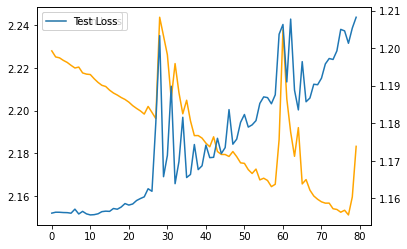

In [24]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.plot(train_loss[20:], label = "Train Loss", color = "orange")
ax2.plot(test_loss[20:], label = "Test Loss")
ax.legend()
ax2.legend()
plt.show()

# Test

In [25]:
# import matplotlib.pyplot as plt
# import torch

In [26]:
# sm_net = torch.load("./pretrained/rating.pth")

In [27]:
# prs = []
# rec = []
# f1 = []
# loss = []

# for i in np.arange(3, 4, 0.1):
#     l, p, r, f, _, _, _ = sm_net.evaluate(i)
#     prs.append(p)
#     rec.append(r)
#     f1.append(f)
#     loss.append(l)
    
# plt.plot(prs, label = "Test Precision")
# plt.plot(rec, label = "Test Recall")
# plt.plot(f1, label = "Test F1")

# plt.legend()
# plt.show()

In [28]:
# prs

In [29]:
# rec

In [30]:
# loss